## Бонусное ДЗ №4 Нейросетевое моделирование следующей корзины

#### В этой домашке вам предстоит реализовать нейросеть, которая моделирует паттерны повторных покупок людей

#### Дата выдачи: 11.06.25

#### Жесткий дедлайн: 18.06.25 23:59 MSK

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/latest.js?config=TeX-AMS-MML_HTMLorMML"></script>

In [39]:
import pandas as pd
import numpy as np
import math
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## Описание задания

В этом задании вам предстоит реализовать нейронную сеть для моделирования поведения пользователей в доменах с высокой частотой повторяющихся взаимодействий между пользователями и товарами (айтемами).

### Структура задания

Задание состоит из трёх основных блоков:

1. **Подготовка данных и базовый подход (макс 3 балла)**
   - Подготовка датасета для экспериментов
   - Реализация простого базового решения (TopPersonal) для последующего сравнения

2. **Реализация нейронной сети BasketHSERec (макс 4 балла)**
   - Реализация архитектуры, моделирующей динамику взаимодействий пользователя с каждым конкретным товаром
   - Учёт временных закономерностей в истории покупок

3. **Эксперименты и анализ (макс 3 балла)**
   - Проведение сравнительных экспериментов между предложенной моделью и базовым подходом
   - Анализ результатов и формулирование выводов

### Особенности задачи

Задание фокусируется на сценариях с:
- Высокой повторяемостью покупок (например, продукты питания, бытовая химия)
- Важностью временных паттернов в поведении пользователей
- Необходимостью персонализированных рекомендаций на основе истории взаимодействий

# Описание модели BasketHSERec


Авторам задания не известна научная статья, в которой бы точно описывалась предлагаемая архитектура, однако она частично вдохновлена упрощёнными идеями из следующих работ:
1. [ReCaNet](https://irlab.science.uva.nl/wp-content/papercite-data/pdf/ariannezhad-2022-recanet.pdf)
2. Недавняя статья [SAFeRec](https://arxiv.org/pdf/2412.14302) от авторов курса. На самом деле, BasketHSERec - это SAFeRec, но без трансформерной части, чтобы не усложнять реализацию

## Постановка задачи

Пусть имеется:
- Множество пользователей $u \in U$
- Множество товаров (айтемов) $i \in I$

Для каждого пользователя составим матрицу $W^u \in \mathbb{R}^{T \times |I|}$, где $w_t^u$ - multihot-вектор корзины покупок в момент времени $t$.

Здесь:
- $t$ представляет дискретные периоды времени от 1 до $T$ (например, дни)
- $w_{t,i}^u = 1$, если пользователь купил товар $i$ в момент $t$, и $0$ в противном случае

**Важно**: матрица будет очень разреженной, поэтому необходимо использовать структуры данных для работы с разреженными матрицами. Но, можно попробовать и на full-connected слоях

Задача: предсказать следующую корзину покупок пользователя в момент времени $T+1$ (например, на следующий день).

**Примечание**: при валидации на разных временных отрезках значение $T$ будет разным для разных пользователей.


## Базовый подход (TopPersonal)


Для пользователя $u$ с историей покупок  $W^u \in \mathbb{R}^{T \times |I|}$:

1. **Суммарный вектор покупок**:
   $$
   s^u = \sum_{t=1}^T w_t^u \quad \in \mathbb{R}^{|I|}
   $$
   где $s_i^u$ — сколько раз пользователь $u$ покупал товар $i$.

2. **Добавление популярности товаров**:
   $$
   p_u^{\text{TopPersonal}} = s^u + pop_{i} \quad \in \mathbb{R}^{|I|}
   $$
   Здесь $\text{pop}_i$ - нормированная популярность товара

3. **Рекомендация**:
   - Сортируем товары по убыванию $ p_u^{\text{TopPersonal}} $
   - Топ-$k$ товаров — предсказанная корзина на $T+1$

## Мотивация для BasketHSERec

Рассмотрим вектор $h_u^i \in \mathbb{R}^T$ - строку в матрице $W^u$, соответствующую товару $i$. Если просто просуммировать его элементы, мы получим общее количество покупок товара, но не учтём временные закономерности.

**Пример**: Допустим, мы наблюдаем 10 дней, и пользователь купил кефир в 1-й, 3-й и 7-й дни. Тогда:

$$h_u^i = [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]$$

Простое суммирование частот не учитывает периодичность покупок. Рассмотрим два случая:
1. $[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$
2. $[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]$

В первом случае товар был куплен 10 дней назад, во втором - "вчера". Вероятность повторной покупки во втором случае выше, хотя это также зависит от паттернов покупок товара.

## Архитектура BasketHSERec

Определим модель как:

$$y_u^i = \text{BasketHSERec}(h_u^i) = f(h_u^i, i) \in \mathbb{R}$$

где $y_u^i$ предсказывает вероятность покупки товара $i$ пользователем $u$ в момент времени $T+1$.

### Реализация:
1. Функция $f(h_u^i, i)$:
   - Конкатенируем вектор $h_u^i$ и эмбеддинг товара $i$
   - Пропускаем через несколько полносвязных (FC) слоёв с нелинейной активацией
   - На выходе получаем одно число (вероятность покупки)

2. Функция потерь:
   - Используем бинарную кросс-энтропию для классификации (покупка/нет покупки)
   - **Важно**: рассматриваем только товары, которые пользователь уже покупал ранее


## Описание данных

Для выполнения задания используется датасет **Dunnhumby - The Complete Journey**, содержащий историю покупок пользователей.

**Исходные данные**:  
[Официальная версия на Kaggle](https://www.kaggle.com/datasets/frtgnn/dunnhumby-the-complete-journey)  

**Подготовленная версия**:  
[Яндекс.Диск](https://disk.yandex.ru/d/PPpfc9a4I9Y38w) (удалены лишние колонки для удобства работы)

## Система оценивания

### 1. Подготовка данных (1 балл)
- [ ] Подготовлены обучающий и тестовый датасеты
- [ ] Использована схема разбиения:
  - Leave-one-basket (последняя корзина как тест) **или**
  - Time-based split (последний день как тест)
- [ ] *(Опционально)* Реализована валидационная выборка и перебор параметров

### 2. Реализация TopPersonal (2 балла)
- [ ] Корректно реализован алгоритм TopPersonal
- [ ] Рассчитаны метрики качества:
  - NDCG@3 и Recall@3
  - NDCG@10 и Recall@10
- [ ] Результаты представлены в понятном формате

### 3. Обучение BasketHSERec (2 балла)
- [ ] Реализован код обучения модели
- [ ] Продемонстрирован процесс обучения:
  - Графики обучения/потерь
  - Логи процесса (например, через tqdm)
- [ ] Сохранены веса обученной модели

### 4. Сравнение с TopPersonal (3 балла)
- [ ] Проведено сравнение BasketHSERec и TopPersonal
- [ ] Показано преимущество BasketHSERec по метрикам:
  - NDCG@3/10
  - Recall@3/10
- [ ] Результаты представлены в табличном виде с четкими выводами

### 5. Анализ архитектурных решений (2 балла)
- [ ] Проведено сравнение вариантов BasketHSERec:
  
  | Вариант               | NDCG@3 | Recall@3 | NDCG@10 | Recall@10 |
  |-----------------------|--------|----------|---------|-----------|
  | a) History + Embeddings |        |          |         |           |
  | b) Только Embeddings    |        |          |         |           |
  | c) Только History       |        |          |         |           |
  | TopPersonal (baseline)  |        |          |         |           |

- [ ] Сделаны содержательные выводы о влиянии компонентов модели

In [4]:
df = pd.read_parquet('dunnhumby_norm.pq')
df.head()

,user_id,day,item_id
0,2375,1,1004906
1,2375,1,1033142
2,2375,1,1036325
3,2375,1,1082185
4,2375,1,8160430


### 1. Подготовка данных (1 балл)


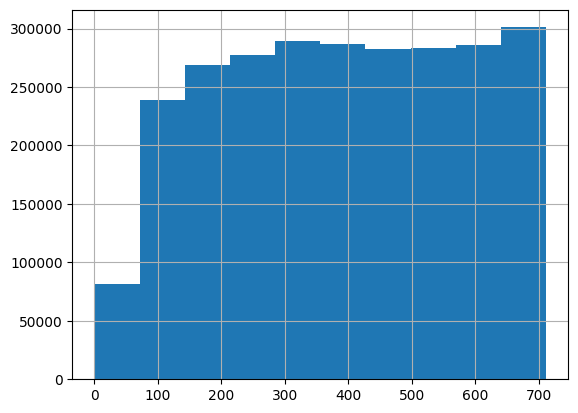

In [5]:
df.day.hist()
plt.show()

Для разбиения на train и test реализуем time-basket split подход:

In [6]:
df.day.min(), df.day.max()

(1, 711)

In [7]:
711 * 0.8

568.8000000000001

In [8]:
train_df = df.loc[(df.day < 568)].copy()
test_df = df.loc[(df.day >= 568)].copy()

In [9]:
train_df.shape[0], test_df.shape[0]

(2005647, 590085)

Сгруппируем айтемы по пользователям и в дальнешем наши прогнозы будем добавлять в качестве отдельной колонки predict (так удобнее реализовать функции расчета метрик):

In [10]:
train_grouped = train_df.groupby('user_id')['item_id'].apply(list).reset_index(name='ground_true')
train_grouped.head()

,user_id,ground_true
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."
2,3,"[866211, 878996, 882830, 904360, 921345, 93194..."
3,4,"[836163, 857849, 877523, 878909, 883932, 89142..."
4,5,"[938983, 5980822, 1012352, 825538, 1002499, 69..."


In [11]:
test_grouped = test_df.groupby('user_id')['item_id'].apply(list).reset_index(name='ground_true')
train_grouped.head()

,user_id,ground_true
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."
2,3,"[866211, 878996, 882830, 904360, 921345, 93194..."
3,4,"[836163, 857849, 877523, 878909, 883932, 89142..."
4,5,"[938983, 5980822, 1012352, 825538, 1002499, 69..."


### 2. Реализация TopPersonal (2 балла)


Реализуем функции для расчета NDCG@k и Recall@k:

In [12]:
def ndcg_at_k(recommended, actual, k):
    recommended_k = recommended[:k]
    actual_set = set(actual)
    dcg = 0.0
    for i, item in enumerate(recommended_k):
        if item in actual_set:
            dcg += 1 / math.log2(i + 2)
    ideal_hits = min(len(actual_set), k)
    idcg = sum(1 / math.log2(i + 2) for i in range(ideal_hits))
    return dcg / idcg if idcg > 0 else 0.0

def mean_ndcg_at_k(df, k):
    ndcgs = []
    for _, row in df.iterrows():
        actual = row['ground_true']
        predicted = row['predict']
        ndcgs.append(ndcg_at_k(predicted, actual, k))
    return sum(ndcgs) / len(ndcgs) if ndcgs else 0.0

In [13]:
def recall_at_k(recommended, actual, k):
    recommended_k = recommended[:k]
    actual_set = set(actual)
    hits = len(set(recommended_k) & actual_set)
    return hits / len(actual_set) if actual_set else 0.0

def mean_recall_at_k(df, k):
    recalls = []
    for _, row in df.iterrows():
        actual = row['ground_true']
        predicted = row['predict']
        recalls.append(recall_at_k(predicted, actual, k))
    return sum(recalls) / len(recalls) if recalls else 0.0

Реализуем алгоритм TopPersonal

In [14]:
class TopPersonalRecommender:
    def __init__(self, all_items):
        self.all_items = all_items
        self.item_to_idx = {item: idx for idx, item in enumerate(all_items)}
        self.idx_to_item = {idx: item for idx, item in enumerate(all_items)}
        self.popularity = None
        self.user_vectors = dict()

    def fit(self, train_df, user_col='user_id', items_col='ground_true'):
        all_purchases = [item for sublist in train_df[items_col] for item in sublist]
        pop_counter = Counter(all_purchases)

        pop_vector = np.zeros(len(self.all_items), dtype=np.float32)
        for item, count in pop_counter.items():
            idx = self.item_to_idx[item]
            pop_vector[idx] = count
        self.popularity = pop_vector / (pop_vector.max() + 1e-8)

        for _, row in train_df.iterrows():
            user = row[user_col]
            items = row[items_col]
            vec = np.zeros(len(self.all_items), dtype=np.float32)
            counts = Counter(items)
            for item, c in counts.items():
                idx = self.item_to_idx[item]
                vec[idx] = c
            self.user_vectors[user] = vec

    def recommend(self, test_df, k=10, user_col='user_id'):
        predicts = []
        for user in test_df[user_col]:
            s_u = self.user_vectors.get(user, np.zeros(len(self.all_items), dtype=np.float32))
            p_u = s_u + self.popularity
            top_indices = np.argsort(-p_u)[:k]
            top_items = [self.idx_to_item[idx] for idx in top_indices]
            predicts.append(top_items)

        result_df = test_df.copy()
        result_df['predict'] = predicts
        return result_df


Обучим модель и сделаем рекомендации:

In [15]:
all_items = train_df.item_id.unique()

In [16]:
model = TopPersonalRecommender(all_items)
model.fit(train_grouped)

In [17]:
recs = model.recommend(test_grouped)
recs.head()

,user_id,ground_true,predict
0,1,"[840361, 856942, 857006, 859676, 868006, 87737...","[856942, 1082185, 995242, 9527290, 940947, 104..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504...","[1106523, 8090521, 5569230, 1133018, 1075368, ..."
2,3,"[946839, 953476, 1053690, 835476, 851057, 8720...","[1092026, 1053690, 951590, 998206, 1106523, 91..."
3,4,"[947095, 951821, 962229, 990797, 6773204, 1311...","[883932, 6391541, 891423, 910109, 936470, 9430..."
4,5,"[833238, 962199, 1026699, 962199, 1003031, 105...","[6904776, 6773079, 1126899, 5995628, 1096036, ..."


Оценим качество модели:

In [18]:
mean_ndcg_at_k(recs, 3), mean_ndcg_at_k(recs, 10)

(0.6656293224503833, 0.5763578649520649)

In [19]:
mean_recall_at_k(recs, 3), mean_recall_at_k(recs, 10)

(0.022692229562410994, 0.050733910837762325)

Как видим NDCG получился весьма неплохой, что лишний раз подтверждает, что простые подходы порой работают не хуже продвинутых моделей. Низкие значения Recall в целом обьяснимы (учитывая маленький k, общее количество релевантных элементов невысоко)

### 3. Обучение BasketHSERec (2 балла)

In [46]:
class BasketHSERec(nn.Module):
    def __init__(self, num_items, embed_dim=64, hidden_dim=128, history_length=10):
        super().__init__()
        self.num_items = num_items
        self.embed_dim = embed_dim
        self.history_length = history_length

        self.item_embedding = nn.Embedding(num_items, embed_dim)

        self.fc1 = nn.Linear(history_length + embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_out = nn.Linear(hidden_dim // 2, 1)

    def forward(self, history, item_ids):
        batch_size, num_items, hist_len = history.shape
        assert hist_len == self.history_length

        item_embeds = self.item_embedding(item_ids)

        x = torch.cat([history.float(), item_embeds], dim=-1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc_out(x).squeeze(-1)

        probs = torch.sigmoid(logits)
        return probs

def basket_loss(preds, targets, mask):
    bce = F.binary_cross_entropy(preds, targets.float(), reduction='none')
    masked_bce = bce * mask.float()
    loss = masked_bce.sum() / (mask.sum() + 1e-8)
    return loss

In [47]:
class BasketHSERecRecommender:
    def __init__(self, model, all_items, history_length, device='cpu'):
        self.model = model
        self.model.eval()
        self.all_items = all_items
        self.item_to_idx = {item: idx for idx, item in enumerate(all_items)}
        self.idx_to_item = {idx: item for idx, item in enumerate(all_items)}
        self.history_length = history_length
        self.device = device

    def recommend(self, test_df, user_histories_sparse, k=10, user_col='user_id'):
        predicts = []

        for user in tqdm(test_df[user_col], desc="Predicting"):
            mat = user_histories_sparse.get(user, None)
            if mat is None:
                predicts.append([])
                continue

            history = mat[:self.history_length].toarray()
            history = torch.tensor(history).transpose(0,1).unsqueeze(0).float()
            item_ids = torch.arange(len(self.all_items)).unsqueeze(0)

            history = history.to(self.device)
            item_ids = item_ids.to(self.device)

            with torch.no_grad():
                preds = self.model(history, item_ids)
                preds = preds.squeeze(0).cpu().numpy()

            top_indices = np.argsort(-preds)[:k]
            top_items = [self.idx_to_item[idx] for idx in top_indices]
            predicts.append(top_items)

        result_df = test_df.copy()
        result_df['predict'] = predicts
        return result_df

In [48]:
from scipy.sparse import lil_matrix

def prepare_user_histories_sparse(df, history_length, all_items):
    item_to_idx = {item: idx for idx, item in enumerate(all_items)}
    user_histories = dict()

    grouped = df.groupby(['user_id', 'day'])['item_id'].apply(list).reset_index()

    for user, user_df in grouped.groupby('user_id'):
        user_df = user_df.sort_values('day')
        days = user_df['day'].values
        baskets = user_df['item_id'].values

        num_days = len(days)
        mat = lil_matrix((num_days, len(all_items)), dtype=np.float32)  # разреженная матрица

        for i, items in enumerate(baskets):
            for item in items:
                if item in item_to_idx:
                    mat[i, item_to_idx[item]] = 1.0

        if num_days < history_length + 1:
            pad = lil_matrix((history_length + 1 - num_days, len(all_items)), dtype=np.float32)
            mat = lil_matrix(np.vstack([pad.toarray(), mat.toarray()]))
        else:
            mat = lil_matrix(mat.toarray()[-(history_length + 1):])

        user_histories[user] = mat.tocsr()  # храним в CSR формате для экономии памяти

    return user_histories


class BasketDataset(Dataset):
    def __init__(self, user_histories, history_length):
        self.user_histories = user_histories
        self.history_length = history_length
        self.users = list(user_histories.keys())
        self.num_items = next(iter(user_histories.values())).shape[1]

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        mat = self.user_histories[user]
        history = mat[:self.history_length].toarray()
        target = mat[self.history_length].toarray().squeeze()

        item_ids = torch.arange(self.num_items)

        return {
            'history': torch.tensor(history).transpose(0,1),
            'item_ids': item_ids,
            'target': torch.tensor(target),
            'user_id': user
        }

def create_mask(target):
    return (target > 0).float()

Epoch 1/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 finished, avg loss: 0.0585


Epoch 2/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 finished, avg loss: 0.0003


Epoch 3/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 finished, avg loss: 0.0001


Epoch 4/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 finished, avg loss: 0.0001


Epoch 5/5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 finished, avg loss: 0.0000


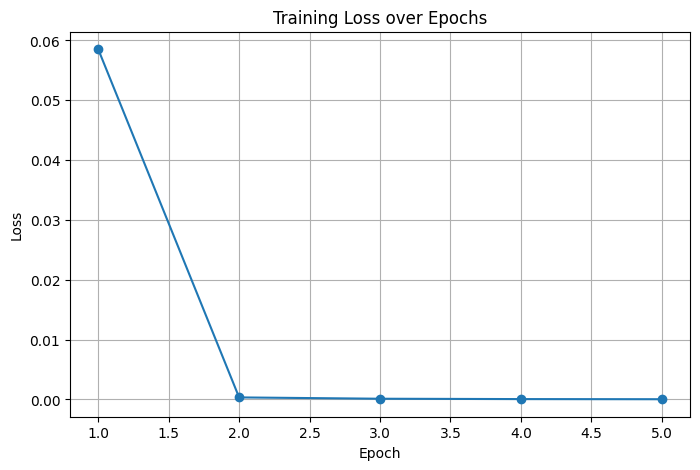

In [50]:
history_length = 10
embed_dim = 64
hidden_dim = 128
batch_size = 16
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


user_histories = prepare_user_histories_sparse(train_df, history_length, all_items)
dataset = BasketDataset(user_histories, history_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = BasketHSERec(num_items=len(all_items), embed_dim=embed_dim, hidden_dim=hidden_dim, history_length=history_length)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_history = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch in tepoch:
            history = batch['history'].to(device)
            item_ids = batch['item_ids'].to(device)
            target = batch['target'].to(device)

            mask = create_mask(target).to(device)

            optimizer.zero_grad()
            preds = model(history, item_ids)

            loss = basket_loss(preds, target, mask)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            avg_loss = total_loss / (tepoch.n + 1)
            tepoch.set_postfix(loss=avg_loss)

    epoch_loss = total_loss / len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1} finished, avg loss: {epoch_loss:.4f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), loss_history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Сохраним веса модели:

In [51]:
torch.save(model.state_dict(), "basket_hserec_final.pth")

### 4. Сравнение с TopPersonal (3 балла)


In [ ]:
recommender = BasketHSERecRecommender(model, all_items, history_length, device=device)
test_with_preds = recommender.recommend(test_df, user_histories, k=10, user_col='user_id')
test_with_preds.head()

### 5. Анализ архитектурных решений (2 балла)